In [1]:
import os
import torch


import numpy as np
import imageio
import pprint

import matplotlib.pyplot as plt

import run_nerf
import run_nerf_helpers

### Load trained network weights

Args:
expname = blender_paper_ship
basedir = ./logs
datadir = ./data/nerf_synthetic/ship
dataset_type = blender

no_batching = True

use_viewdirs = True
white_bkgd = True
lrate_decay = 500

N_samples = 64
N_importance = 128
N_rand = 1024

precrop_iters = 500
precrop_frac = 0.5

half_res = True

Found ckpts ['./logs/blender_paper_ship/050000.tar']
Reloading from ./logs/blender_paper_ship/050000.tar
Not ndc!


/home/lyq/anaconda3/envs/gp/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


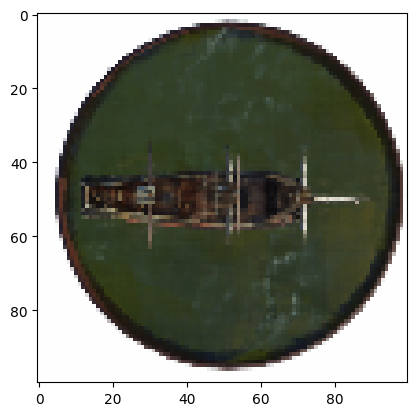

In [2]:
basedir = './logs'
run = 'ship'

if run == 'ship':
    expname = 'blender_paper_ship'
    ckpt = '050000.tar'
    dataset = 'ship' # used when config file of pretrained model not provided

elif run == 'lego':
    expname = 'lego_test'
    ckpt = '200000.tar'
    dataset = 'lego'


torch.set_default_tensor_type('torch.cuda.FloatTensor')

try:
    config = os.path.join(basedir, expname, 'config.txt')
    print('Args:')
    print(open(config, 'r').read())
except Exception as e: # config file not provided
    config = os.path.join('./configs', dataset+'.txt')
    print('Args:')
    print(open(config, 'r').read())


parser = run_nerf.config_parser()
device = "cuda" if torch.cuda.is_available() else "cpu"

ft_str = '' 
ft_str = '--ft_path {}'.format(os.path.join(basedir, expname, ckpt))
args = parser.parse_args('--config {} --ft_path {} --device {}'.format(
                                                            config, 
                                                            os.path.join(basedir, expname, ckpt),
                                                            device
                                                            ))
# pprint.pprint(args)
# Create nerf model
_, render_kwargs_test, start, grad_vars, models = run_nerf.create_nerf(args)

net_fn = render_kwargs_test['network_query_fn']

# Render an overhead view to check model was loaded correctly
c2w = torch.eye(4, dtype=torch.float32)# identity pose matrix
c2w[2,-1] = 4.
# c2w = c2w.to(device)

near = 2.
far = 6.
bds_dict = {
        'near' : near,
        'far' : far,
    }
render_kwargs_test.update(bds_dict)

H, W, focal = 800, 800, 1200.
down = 8
H, W, focal = H//down, W//down, focal/down

K = np.array([
    [focal, 0, 0.5*W],
    [0, focal, 0.5*H],
    [0, 0, 1]
])

with torch.no_grad():
    rgb, disp, acc, _ = run_nerf.render(H, W, K, chunk=args.chunk, c2w=c2w[:3,:4], **render_kwargs_test)
test = rgb.cpu().numpy()
img = np.clip(test,0,1)
plt.imshow(img)
plt.show()


### Query network on dense 3d grid of points

(257, 257, 257, 3)
(257, 257, 257, 4)


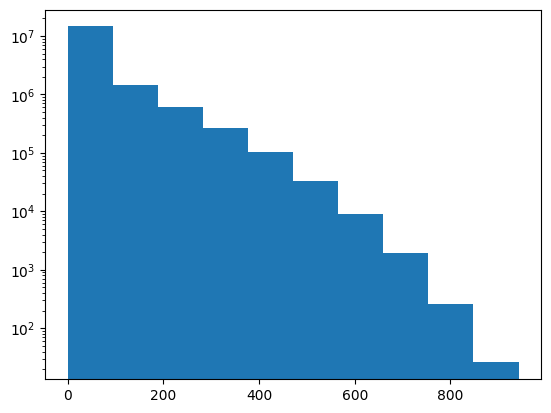

In [3]:
N = 256
t = np.linspace(-1.2, 1.2, N+1)

query_pts = np.stack(np.meshgrid(t, t, t), -1).astype(np.float32)
print(query_pts.shape)
sh = query_pts.shape
flat = query_pts.reshape([-1,3])
flat = torch.tensor(flat)
    
fn = lambda i0, i1 : net_fn(flat[i0:i1,None,:], viewdirs=torch.zeros_like(flat[i0:i1]), network_fn=render_kwargs_test['network_fine'])
chunk = 1024*64
with torch.no_grad():
    raw = torch.concatenate([fn(i, i+chunk) for i in range(0, flat.shape[0], chunk)], 0)
raw = torch.reshape(raw, list(sh[:-1]) + [-1])
raw = raw.cpu().numpy()
sigma = np.maximum(raw[...,-1], 0.)

print(raw.shape)
plt.hist(np.maximum(0,sigma.ravel()), log=True)
plt.show()

### Marching cubes with [PyMCubes](https://github.com/pmneila/PyMCubes)
Change `threshold` to use a different sigma threshold for the isosurface

In [4]:
import mcubes

threshold = 50.
print('fraction occupied', np.mean(sigma > threshold))
vertices, triangles = mcubes.marching_cubes(sigma, threshold)
print('done', vertices.shape, triangles.shape)

Cuda needs to be compiled first
fraction occupied 0.2285067453458236
done (1550171, 3) (3072618, 3)


### Live preview with [pyvista](https://docs.pyvista.org/version/stable/)
Click and drag to change viewpoint

install
```
pip install 'jupyterlab>=3' ipywidgets 'pyvista[all,trame]'
```

pyvista is more powerful, but you can use [trimesh](https://github.com/mikedh/trimesh) for simplity

In [6]:
import pyvista as pv

def face2pv_face(faces):
    faces = np.array(faces, dtype=np.int32)
    index = np.repeat(3, faces.shape[0]).reshape(-1,1).astype(np.int32)
    faces = np.concatenate((index, faces),axis=1)
    faces = faces.flatten()
    return faces

faces = face2pv_face(triangles)

mesh = pv.PolyData(vertices, faces)

plotter = pv.Plotter()
pv.set_jupyter_backend('client')
plotter.add_mesh(mesh, show_edges=False)
plotter.show(jupyter_backend='trame')

Widget(value="<iframe src='http://localhost:38033/index.html?ui=P_0x7f3f5f78bbb0_1&reconnect=auto' style='widt…